# **Assignment 3 - The Secret Keepers**


# Block Cipher and RSA

In [3]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from Cryptodome.Cipher import AES
from Cryptodome.Util import Counter

## Block Cipher and AES

**Block Ciphers** are a different kind of encrypting systems that, as suggested by the name, work in a block-wise manner: the blocks taken into account consist on portions of the total plaintext, which gets usually subdivided into 128-bits portions. These systems' structures are composed of sequential *ciphering rounds*, each one applying a different function to the data block, in order to provide both confusion and diffusion alternately; in order to allow the implementation of the same structure both to encrypt and decrypt, all functions need to be invertible. The key can be of different lenghts, 128, 192 or 256 bits, and, given the peculiar conformation of the system, it needs a way to be managed securely: each block gets a *round key* as input, obtained by an expansion of the original key, and, in addition, there are multiple *modes of operation* to allow the repetition of the key in a secure way.

**Advanced Encryption Standard** (**AES**) is one possible realization of a Block Cipher: its backbone is based on the *Rijndael Block Cipher*, which is made of one **key expansion** block, strictly linked to a complex **data path**, itself composed by multiple *round blocks*; the number of rounds depends on the lenght of the key. The encoding of the plaintext is realized making it pass through the whole datapath sequentially. The rounds are again divided into 3 or 4 blocks, depending on their position in the data path: generally, each round is the sequence of a <span style="color:lightgreen">byte substitution</span> function, a <span style="color:blue">shift rows</span> and <span style="color:blue">mix columns</span> functions and finally a <span style="color:red">key addition</span> function. The first of the four is the most important, since its non-linearity provides the required confusion; the two intermediate layers are linear and are useful to apply diffusion; lastly, the addition layer is a simple XOR between the round key and the intermediate cipher result, which is the state in that position. 

Now let's look at the most important block among all, the key expansion one: the *key scheduling* applied for this cipher is peculiar and slightly differs for each possible key length. Its functioning is sequential, reason why the computation of each round key is executed round per round; here relies the only complication, related to the decryption process: to decrypt any ciphertext all the round keys need to be processed in advance and then all used in their inverse order.

![AES](AES2.jpg)

### Modes of operation

There exist many *modes of operation* related to Block Ciphers in general, each one slightly different from the others. Let's look at some of them: the easiest and most straight-forward one is called **Electronic Codebook** (**ECB**), which provides a simple encryption of each block of the plaintext with the key, similarly to any deterministic encryption scheme such as substitution ciphers; an improvement of this mode, called **Cipher Block Chaining** (**CBC**), adds a layer of complexity, mixing the current plaintext block with the previous ciphertext block with a XOR function, before giving it as input to the BC. In order to furtherly complicate the relation between plain and cipher texts there have been found many solutions: for example **Cipher Feedback** (**CFB**) uses an *initialization vector* (IV) for the BC block and the Block Cipher as a sort of Stream Cipher system to generate a keystream block, while **Counter** (**CTR**) crates the keystream block from the value of a counter properly positioned.

![Modes of operation](Modes.jpg)

Load the plaintext stored as `secret_message.bin`.
The plaintext is a serialized 2048 x 2912 grayscale image in which each pixel is an 8bit integer. Serialization transformed the 2D image into a byte string by concatenating the rows and transforming each 8bit pixel into a byte.

In [4]:
with open(file='secret_message.bin', mode='rb') as f:
    plaintext = f.read()

Process the plaintext in order to retrive the original image and then visualize it.

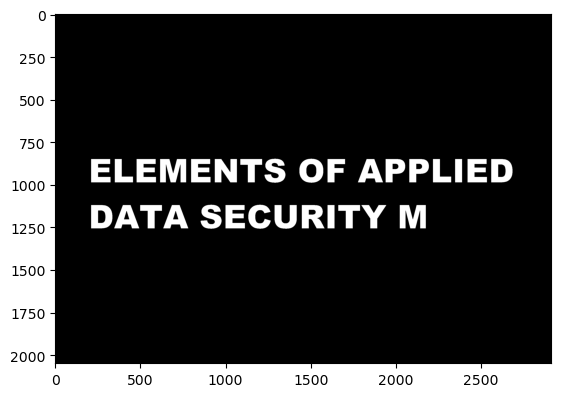

In [5]:
image = np.array([byte for byte in plaintext]).reshape(2048, 2912)

plt.imshow(image, cmap="gray")

Using AES, for each operation mode (ECB, CBC, CTR and CFB) encrypt and decrypt the image

In [6]:
key = b'0123456701234567'

iv = random.randbytes(16)

# ECB mode:
cipher = AES.new(key, AES.MODE_ECB)
ciphertext_ECB = cipher.encrypt(plaintext)
cipher = AES.new(key, AES.MODE_ECB)
plaintext_ECB = cipher.decrypt(ciphertext_ECB)

# CBC mode:
cipher = AES.new(key, AES.MODE_CBC, iv=iv)
ciphertext_CBC = cipher.encrypt(plaintext)
cipher = AES.new(key, AES.MODE_CBC, iv=iv)
plaintext_CBC = cipher.decrypt(ciphertext_CBC)

nonce = random.randbytes(8)
counter = Counter.new(32, prefix=nonce, suffix=b'ABCD', little_endian=True, initial_value=10)

# CTR mode:
cipher = AES.new(key, AES.MODE_CTR, counter=counter)
ciphertext_CTR = cipher.encrypt(plaintext)
cipher = AES.new(key, AES.MODE_CTR, counter=counter)
plaintext_CTR = cipher.decrypt(ciphertext_CTR)

# CFB mode:
cipher = AES.new(key, AES.MODE_CFB, iv=iv)
ciphertext_CFB = cipher.encrypt(plaintext)
cipher = AES.new(key, AES.MODE_CFB, iv=iv)
plaintext_CFB = cipher.decrypt(ciphertext_CFB)

For each mode of operation visualize the ciphertext as an image

ECB Mode:


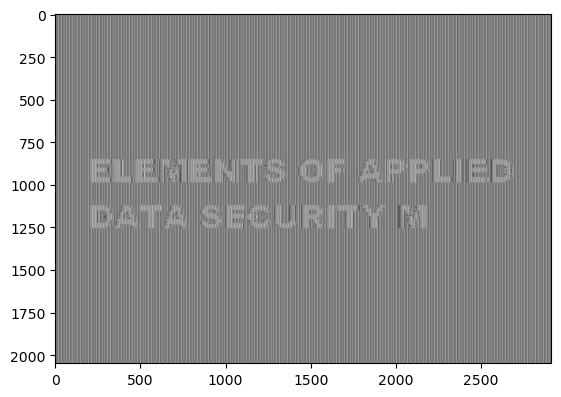

In [7]:
print(f'ECB Mode:')
plt.imshow(np.array([byte for byte in ciphertext_ECB]).reshape(2048, 2912), cmap="gray")

CBC Mode:


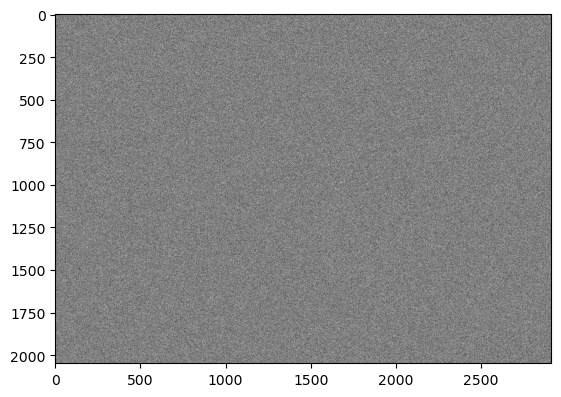

In [8]:
print(f'CBC Mode:')
plt.imshow(np.array([byte for byte in ciphertext_CBC]).reshape(2048, 2912), cmap="gray")

CTR Mode:


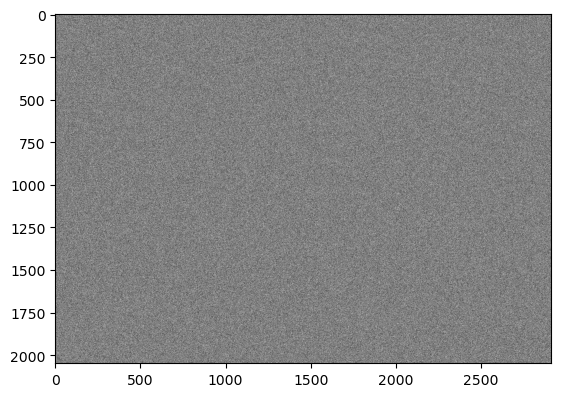

In [9]:
print(f'CTR Mode:')
plt.imshow(np.array([byte for byte in ciphertext_CTR]).reshape(2048, 2912), cmap="gray")

CFB Mode:


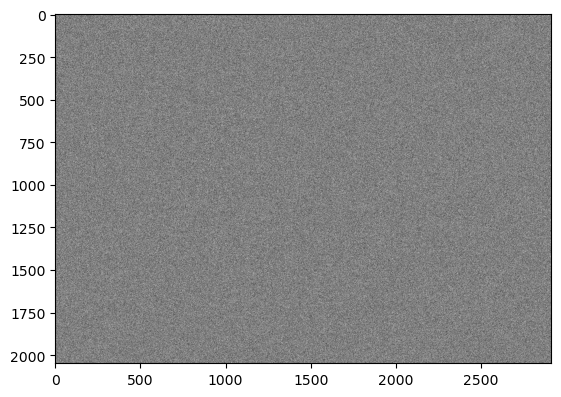

In [10]:
print(f'CFB Mode:')
plt.imshow(np.array([byte for byte in ciphertext_CFB]).reshape(2048, 2912), cmap="gray")

From these results we can quickly acknowledge the effectiveness of all the different modes: the last three seem to be quite effective when working with images, since the initial plaintext image results impossible to see; the first method instead, the Electronic Codebook mode, actually works worse than all the others, as we can clearly see the text that was present in the not-encrypted image.

## RSA

The **Rivest-Shamir-Adleman** (**RSA**) algorithm is a different approach in key usage, thanks to which it is possible to achieve a safer level of cryptography: usual methods rely on *symmetric* systems, where both sender and receiver share a common key, that needs a secure channel to be sent safely; instead, RSAs are asymmetric, in the sense that receiver and sender don't share all the information: the whole key is divided into two components, the <span style="color:lightblue">*private key*</span> that is needed to decrypt the ciphertext and is held only by the receiver, and the <span style="color:pink">*public key*</span>, which is used during the encryption and can be sent from Bob to Alice without any concern. This kind of algorithm is usually employed on top of a symmetric encryption/decryption scheme just to exchange the key in a totally safe way.

![RSA](RSA2.jpg)

### Square and Multiply

To realize an RSA system we need to implement many complex mathematical functions, such as the exponantiation of large numbers: an algorithm able to realize it in an easyer way, from a computational point of view, is called **Square-and-Multiply** and the idea behind its functioning is the following: displaying the exponent in its binary representation, we get the summation of many powers of 2; after a series of groupings, only multiplications by 2 and additions by 1 remain. Once put as the exponent, any addition by 1 becomes a multiplication of the base by itself and any multiplication by 2 becomes a squaring of the base. This way we reduced the needed number of operations by a lot.

In [11]:
def square_and_multiply(base, exp, mod):
    '''
    Computes the exponantiation (base^exp)%mod by means of squaring and multiplication, 
    drastically reducing the required amount of operations.
    ----------
    base: int,
        exponent's base,
    exp: int, 
        exponent's value,
    mod: int,
        modulus' value.

    Return
    ------
    int,
        result of the operation
    '''
    
    number = 1
    exp_list = []
    [exp_list.append(int(x)) for x in bin(exp)[2:]]
    length = len(exp_list)

    for i in range(length):
        number = (number ** 2) % mod
        if (exp_list[i] == 1):
            number = (number * base) % mod

    return number

testing

In [12]:
base = 3
exp = 0b001101 # exp = 13
mod = 747

result = square_and_multiply(base, exp, mod)
print(f'Result of ({base} ^ {exp}) mod {mod}: {result}')

Result of (3 ^ 13) mod 747: 225


### Miller Rabin test

Another practical issue is related to the identification of two big prime numbers; the general approach to this need requires a valid method to test the primality of any given number, which is not an easy task, since prime numbers have no regularity: the **Miller-Rabin test** is exactly what we need. Its algorithm determines whether a number is likely to be prime or is surely composite, with a probability of correctness close to 4 to the power of (- number of trials). The odd number given as input gets, first of all, factorized in the form ((q*2^r) + 1); then, for a number of times equal to the number of trials, a number x is drawed in the range [2, (candidate number - 2)] and the testing begins, using *Fermat's Little Theorem* as checking rule.

In [13]:
def miller_rabin_test(number, num_trials=None):
    '''
    Determines whether number is likely to be prime (with probability 4^-num_trials)
    or surely composite.
    ----------
    number: int,
        integer to test,
    num_trials: int, optional (default None)
        number of times the test will be performed.

    Return
    ------
    bool,
        True if number is likely prime,
        False if it is surely composite.
    '''
    
    r = 0
    q = number - 1

    while not (q % 2): # (number - 1) factorization in (q*2^r)
        q = int(q / 2) #
        r += 1         #

    #print(f'{number} is factorized as [{q}*(2^{r})]+1')
    
    if (number % 2 == 0):
        raise ValueError(f'You should input an odd number, {number} is even.')

    for j in range(num_trials):
        x = random.randint(2, (number - 2))
        y = square_and_multiply(x, q, number)
        if (y == 1 or y == (number - 1)):
            continue

        for i in range(r - 1):
            y = square_and_multiply(y, 2, number)
            if (y == (number - 1)):
                break
        else:
            return False
    
    return True
 

testing

In [14]:
# Test on a random odd number:
number = 0
while (number % 2 == 0):
    number = random.randint(10000000000000, 100000000000000000)

if (miller_rabin_test(number, num_trials=10)):
    print(f'The number {number} is a prime number')
else:
    print(f'The number {number} is a composite number, try with another one')

print()
# Test cycled for many random odd numbers until a prime one is found:
prime_num = 0
while (prime_num == 0):
    number = 0
    while (number % 2 == 0):
        number = random.randint(100000000000000000, 1000000000000000000000)
    if (miller_rabin_test(number, num_trials=10)):
        prime_num = number

print(f'The number {prime_num} is prime.')

The number 63645680076242879 is a composite number, try with another one

The number 115818169993040017 is prime.


### Extended Eucledian Algorithm

The last problem requires the **Extended Euclidean Algorithm** (**EEA**), which is fundamental when we have to compute the modular inverse of any number, when existent. This computation is carried out everytime, in the RSA, the private key is needed, since d is the inverse of e with respect to the multiplication modulo m (d*e ≡ 1(mod m)). The idea is that the gcd (*great common divisor*) between any two numbers can be expressed as a linear combination of the two, affirmation that leads to the existence of the modular inverse, under precise circumstances, through a series of mathematical manipulations.

In [15]:
def extended_eucledian_algorithm(a, m):
    '''
    Computes the inverse of a with respect to multiplication modulo m, 
    when the inverse exists; otherwise, it raises an error.
    ----------
    a: int,
        number ∈ Nm, such that (a^-1)%m is equal to the result,
    m: int, 
        modulus' value. 

    Return
    ------
    int,
        value of the inverse, if existent.
    '''

    (r0, r1) = (m, a)
    (t0, t1, s0, s1) = (1, 0, 0, 1)

    while (r0 != 0):
        (quotient, r1, r0) = (r1 // r0, r0, r1 % r0)
        (t0, t1) = (t1, t0 - quotient * t1)
        (s0, s1) = (s1, s0 - quotient * s1)

    if (r1 != 1):
        raise ValueError(f'The inverse doesn\'t exist.')

    if(t0 < 0):     #
        t0 = t0 + m # This is needed to handle a negative result
    return t0


testing

In [16]:
a = 5
m = 5568

result = extended_eucledian_algorithm(a, m)

# Test:
if (not (result * a) % m):
    print('Ops, there might be a problem...')
    
print(f'The inverse of ({a} mod {m}) is {result}')

The inverse of (5 mod 5568) is 3341


### Implementation

Implement the RSA class. The role of sender (`Alice`) or receiver (`Bob`) depends on the arguments passed when an instance is created. In detail:
- if `k_pub` is passed RSA instance works as sender (`Alice`)
- Otherwise, RSA instance works as receiver (`Bob`). Therefore, it must generate `k_priv` and `k_pub`.

In [17]:
class RSA():
    
    def __init__(self, key_length=128, k_pub=None, mrt_trials=None):
        ''' 
        Initialization of the RSA system.
        When the public key isn't provided, the system is required to compute all the keys.
        ---------
        key_length: int, (default 128 bits)
            length of the key,
        k_pub: tuple, optional (default None)
            (e, n) tuple, representing the public key computed by the receiver (Bob) and transmitted to the sender (Alice),
            when given as input to the RSA it means that we are dealing with the receiver part,
        mrt_trials: int, optional (default None)
            number of trials required for the sampling of prime numbers,
            can be specified after.

        Internal variables
        --------
        self.n: int, (Public)
            second half of the public key,
        self.e: int, (Public)
            first half of the public key,
        self.d: int, (Private)
            private key,
            not meant to be shared.
        '''
        
        self.key_length = key_length

        if (mrt_trials != None):
            self.mrt_trials = mrt_trials
        
        if (k_pub != None):
            self.n = k_pub[0] #
            self.e = k_pub[1] # Public key (n, e)
        else:
            # Key generation:
            # p = self._sample_prime_number(length = self.key_length / 2) #
            # q = self._sample_prime_number(length = self.key_length / 2) # Random prime values for p and q, random case

            p = 0x1083e935648922e73 #
            q = 0x1cc1a881e36821695 # Debug (2)

            self.n = p * q
            m = (p - 1) * (q - 1)

            self.e = 0
            test_num = 2

            while (self.e == 0):
                test_num += 1                    # We look for a coprime number to m
                if (math.gcd(test_num, m) == 1): #
                    self.e = test_num            #

            print(f'The public key is the following: ({self.n}, {self.e})')

            self.d = extended_eucledian_algorithm(self.e, m) # Private key d

    def _sample_prime_number(self, length, mrt_trials=None): # length needs to be half of the key length
        '''
        Used to find two big prime numbers for p and q variables, 
        takes advantage of the Miller-Rabin test to return such values.
        ----------
        length: int,
            length in bits required for the number,
            in this case it should be half of the total key length,
        mrt_trials: int, optional (default None)
            number of trials required for the Miller-Rabin test,
            if not specified before. 

        Return
        ------
        int,
            random prime number belonging to the interval [2**(length-1),  2**(length)-1].
        '''
        
        if (mrt_trials != None):
            self.mrt_trials = mrt_trials
        number = 0

        while (number == 0):
            sample = random.randint(2**(length - 1),  2**(length) - 1)
            if ((sample % 2) == 1):
                if (miller_rabin_test(sample, self.mrt_trials)):
                    number = sample

        return number
    
    def decrypt(self, y): # Bob, receiver
        '''
        Decryption of the ciphertext using the private key d and part of the public key n,
        performed as (ciphertext^d)%n.
        ----------
        y: int,
            encrypted ciphertext.

        Return
        ------
        int,
            outputs the decrypted plaintext.
        '''

        x = square_and_multiply(y, self.d, self.n)

        return x
    
    def encrypt(self, x): # Alice, sender
        '''
        Encryption of the plaintext using the public key (e,n),
        performed as (plaintext^e)%n.
        ----------
        x: int,
            plaintext.

        Return
        ------
        int,
            outputs the encrypted ciphertext.
        '''
        
        y = square_and_multiply(x, self.e, self.n)

        return y

testing

In [18]:
x = 0x30313233343536373031323334353637 # Debug (2)

print(f'Plaintext: {hex(x)}')
Bob = RSA(mrt_trials=10)

Plaintext: 0x30313233343536373031323334353637
The public key is the following: (631278551587732464960146165791630879471, 3)


To work in a random way, without the imposition of any predetermined value for p, q or any other variable, `we need to copy the public key and give it as input to Alice`, manually; in the following case, just to display the correct behaviour, I used fixed values.

In [19]:
Alice = RSA(k_pub=(631278551587732464960146165791630879471, 3)) # Debug (2)
# Alice = RSA(k_pub=(144899223735680116753240677746549262337, 3)) # Random case

y = Alice.encrypt(x)
print(f'Ciphertext: {hex(y)}')

x_dec = Bob.decrypt(y)
print(f'Decrypted plaintext: {hex(x_dec)}')

if (x_dec != x):
    print('The received plaintext is incorrect...')
else:
    print('Correct, everything worked just fine!')

Ciphertext: 0x12366ac62e7b46d1a1f676a2b97d965d2
Decrypted plaintext: 0x30313233343536373031323334353637
Correct, everything worked just fine!


##  RSA+AES

As mentioned before, it's common to design any symmetric encryption/decryption scheme together with an asymmetric key exchanging algorithm, on top of it, in order to provide a secure communication channel, where Alice and Bob are able to share the common key without any concern. Let's look at one possible implementation, depicted in the following image: the foundations of the whole system consist of a simple AES Block Cipher, where the message gets encrypted and securely sent through the channel; to achieve a greater level of security, an RSA system is implemented in order to encrypt also the common key of the AES, with the well known algorithm explained before. This way, the only non-encrypted piece of information passing through the channel is the public key of the asymmetric scheme, which can be shared freely by its nature.

<img src="system.png" width="600">

With the reference to the previous picture, given an AES key `k_AES = b'0123456701234567'` and a ciphertext stored in `ciphertext_AES.bin`,
simulate a system based on RSA and AES, that allows Bob to decrypt the ciphertext.

In [28]:
k_AES = b'0123456701234567'

with open(file='ciphertext_AES.bin', mode='rb') as f:
    ciphertext_AES = f.read()

print(f'Ciphertext: {ciphertext_AES}')

# AES key transmission through RSA:
Bob_RSA = RSA() # Public RSA key is given to Alice
Alice_RSA = RSA(k_pub=(631278551587732464960146165791630879471, 3))

k_AES_enc = Alice_RSA.encrypt(int(k_AES)) # This encrypted key will be delivered to Bob


Ciphertext: b"\xfe\x87/\xb8e\xce\xca,/w\x17\x0f.Y\xae\xb3\xd4\x96\xf6\xd4\xa3b\x87\x02\x881\xfc\x9c\xf7\xa1\x16+\xb1'\xb4\xea\xc8kD\xed\x93\x88\xbf\x7f\x11\x17\x92\x10\xf0\x80\xde\xa44\xf4\xcb\xe5w\x8b\x13%\x86\xbe\xc0\xf6WL\xe3\nT\xf2.\xb2\x9d\xb2\xbe\x88T\x98\x11\xb8/\xc9\xcc\x9d\x12\x0c\x01\xb2\x19\xa9\xcf\xb3]\x16\x9c\xdf\x05+0\x06\x8d\xf61\xab\xa7\x05\xae\xc9\xab\x11\xf8\xc7q\xe8l)\xc0\xbbh\xc8\xee\x84\x91\xd6R\xcbi\re\xca=5L\x9c\xe0\x84\x95\xd43\x8a\xf0\xae\xfe>\x0e\x07\xdb\x0er{\xc5\xdf\xc7\x9cB\xe1\xb7e\xf9u\x9ce\xad\x18\xaa\x14\x85x\x0e\xbb\xb8\xfe\xf9\xbc\x0c\xf5^{\xf1\nk\xf2\x98>\n\xb91P\xb3\xa5\x1f\xe1D\x84\x92\x9e\xce\t\xaci\x8d!u\xd2\xb8oz\xcc\xa5\xa6E\xe7\x1f\xfa\xbb\xa8\x19K\x82\xd6\xb9\x0e\x99\x90\xe0\xb3R\xe19\\[;\xee\xf6\xff\xe1\x08\xc8h\xdc\xc7\xb6\x95\xac\xd2\x00\xe5\x02R\xf7\x1e\xd1]\xc2\x80O.\xc0\x1c\x15\xb6\x0fE\x93\x06\xe8\x0c8:=\xd8[\x1d\xffkqn\x7f\xc3\x9c\xe7\x81\x92\xff\x8d\xb3C\x0c{Q\x86B\x98`\x7f\xdb\xe6\x15d\x01\xd7y&\x82\xad\xdf\x1c\x01B\xf3\x89\xa5CN\xe

In [88]:
# AES key decryption by Bob:
k_AES_dec = Bob_RSA.decrypt(k_AES_enc)

if (k_AES_dec == int(k_AES)):
    print('The AES key has been correctly delivered to Bob.')

# AES decryption of the message in ECB mode:
while (len(str(k_AES_dec)) < 16):          #
    k_AES_dec = "0" + str(k_AES_dec)       #
k_AES_dec = bytes(str(k_AES_dec), "utf-8") # Correct formatting of the key into 16 bytes (128 bits)

BC = AES.new(k_AES_dec, AES.MODE_ECB)
plaintext_ECB = BC.decrypt(ciphertext_AES)
print(f'Decrypted plaintext: {bytes(plaintext_ECB)}')

The AES key has been correctly delivered to Bob.
Decrypted plaintext: b'Agent 007 to MI6. I am currently in an undisclosed location and have uncovered some critical information regarding the solution to a top-secret assignment. The assignment in question is code-named "Block Cipher" and the solution has been compromised by an unknown entity. It is imperative that we secure the solution before it falls into the wrong hands. My coordinates are 44.4885 N, 11.3290 E. I have obtained the location of the individual who possesses the solution, but I need immediate backup to help me retrieve it. Please send a team to rendezvous with me at the designated location. Code name for the mission is "Mercury Rising". Await further instructions.      '


## Bouns task

### Fixed-size integer operations

Python allows to work with arbitrary large integers, providing an abstraction called *bignum arithmetic*. Of course any datum being processed by the processor needs to be of the same fixed size of both registers and data bus, in order to be stored and moved around, and today's CPUs are usually 64-bit; for this reason, any variable of the python script we run gets divided into 8-byte portions, in order to match the required dimension. We want do implement a class, named **BigInt**, able to realize addition and multiplication in *512-bit arithmetic* relying on *64-bit parallelism*.

In [4]:
def bits_to_integer(bits):
    '''
    Given a list of bits its integer representation is generated
    EX: [1, 0, 1, 1] -->  11 (0b1011)
    ----------
    bits: list,
        the list of bits (each represented with an integer 0/1 or a bool)

    Return
    ------
    int,
        integer having the binary representation defined by the list
    '''
    
    integer = 0
    
    for bit in bits:
        integer = (integer << 1) ^ bit
        
    return integer

In [130]:
class BigInt:
    def __init__(self, value=None, ndigit=None):
        ''' 
        ---------
        value: int/byte, (default None)
            integer represented as a byte string or directly as an integer,
        ndigit: int, (default None)
            number of digits that must be used to represent value in a vector form.
            (ndigit=None -> ndigit has to be inferred by value)
            (ndigit=None and value=None -> ndigit=1)

        Internal variables
        --------
        self.values: array,
            vector representation of value, made of #ndigit hexadecimal blocks of maximum 64-bit (8-byte) each.
            (value=None -> self.values=np.array([]))
        '''
                               
        if (value is not None and type(value) is bytes): #
            value = int.from_bytes(value, "big")         # Conversion of bytes into integer

        if (ndigit is None and value is None):
            ndigit = 1
        elif (ndigit is None):
            ndigit = math.ceil(len(bin(value)[2:])/64) # We consider as default a 64-bit representation

        if (value is not None):
            value_bin = []
            [value_bin.append(int(x)) for x in bin(value)[2:]]

            while (len(value_bin) < 512):   #
                value_bin = [0] + value_bin # Adding the needed 0s at the beginning to have exactly 512 bits
 
            values = []
            for digit in range(ndigit):
                values.append(bits_to_integer(value_bin[(64 * digit): (64 * digit) + 64]))

            values = [hex(element) for element in values]
            for i in range(len(values)):
                while (len(values[i]) < 18):
                    element = values[i]
                    values[i] = element[:2] + '0' + element[2:] # Adding 0s until we have 16 exadecimal literals

            self.values = np.array(values) # Conversion of value into its self.values array, made of 64-bit block

            #print(f'Representation of {value} \nas an hexadecimal 64-bit blocks division: \n{self.values}')

        else:
            self.values = np.array([]) # Empty array

    def __add__(self, x):
        '''
        Performs the sum between self and another BigInt number.
        ----------
        x: BigInt,
            second addend.

        Return
        ------
        np.array,
            outputs c = self + x, formatted as a numpy array of 64-bit blocks of hexadecimal strings.
        '''

        c = np.array([])
        carry = 0

        # self/x.values:
        #['0x.....' '0x.....' '0x.....' ..... '0x.....'] - 8 elements if we work with 512-bit addends

        for elementA, elementB in zip(reversed(self.values), reversed(x.values)):
            hex_sum = " " # Empty string
            for literalA, literalB in zip(reversed(elementA[2:]), reversed(elementB[2:])):
                sum = int(literalA, 16) + int(literalB, 16) + carry
                if (sum > 15):
                    carry = int(sum / 16)
                    sum = int(sum % 16)
                else:
                    carry = 0

                hex_sum += hex(sum)[2:]
            hex_sum += "x0"
            c = np.append(c, hex_sum[::-1].strip())

        if (carry != 0):
            c = np.append(c, '0x' + str(carry))
            #print('\n(the sum exceeded 512 bits)')

        return (c[::-1]) # Reversed array with slicing
    
    
    # MUL NOT WORKING
    def __mul__(self, x): 
        '''
        Performs the product between self and another BigInt number.
        ----------
        x: BigInt,
            second factor.

        Return
        ------
        np.array,
            outputs c = self * x, formatted as a numpy array of 64-bit blocks of hexadecimal strings.
        '''

        c = np.array([])

        for elementB in reversed(x.values):
            for elementA in reversed(self.values):
                iB = 0
                for literalB in reversed(elementB[2:]):
                    iA = 0
                    for _ in range(iB):
                        literalB += '0'
                    iB += 1
                    for literalA in reversed(elementA[2:]):
                        for _ in range(iA):
                            literalA += '0'
                        iA += 1
                        prod = int(literalA, 16) * int(literalB, 16)

        # WASN'T ABLE TO FINISH THIS METHOD...

        return c
    
    
    def __str__(self):
        ''' Function used to print the integer value of the BigInt number '''

        hex_value = " "

        for element in self.values:
            hex_value = hex_value + element[2:]
            hex_value.strip() # Removing all white spaces

        return f'Integer value: {int(hex_value, 16)}'


In [108]:
def long_sum(a, b):
    '''
    Performs the addition between two big integers, 
    transforming them into BigInt() objects.
    ----------
    a, b: int,
        addends of the addition.

    Return
    ------
    int,
        outputs the result formatted as an integer.
    '''

    A = BigInt(a)
    B = BigInt(b)

    # c = a + b --> sum 512 bit integers
    c = A + B
    
    hex_value = " "
    for element in c:
        hex_value = hex_value + element[2:]
        hex_value.strip() # Removing all white spaces

    return int(hex_value, 16)

def long_mul(a, b):
    '''
    Performs the product between two big integers, 
    transforming them into BigInt() objects.
    ----------
    a, b: int,
        factors of the multiplication.

    Return
    ------
    int,
        outputs the result formatted as an integer.
    '''

    A = BigInt(a)
    B = BigInt(b)

    # c = a * b --> multiply 512 bit integers
    c = A * B
    
    hex_value = " "
    for element in c:
        hex_value = hex_value + element[2:]
        hex_value.strip() # Removing all white spaces

    return int(hex_value, 16)

Testing

In [128]:
# Generation of two 512-bit random unsigned integers:
(i1, i2) = (random.getrandbits(512), random.getrandbits(512))
print(f'i1: {i1}')
print(f'i2: {i2}')

# Generation of two 512-bit random unsigned integers in byte form (64 bytes):
(b1, b2) = (random.randbytes(64), random.randbytes(64))
print(f'b1: {b1}')
print(f'b2: {b2}')


i1: 11588385345207329349173227323372625537025321040648665591498501437103658330854852527239323500793468798390507586610219322628594696128556170336032057246039505
i2: 8106114885432656835147196044991756894155030466890717700198243339625271861300019402112681719532486172749606046543371609806693755764912818686729938519950123
b1: b'\xae]s\xb3o\x9c\xeaQ\x04\x1dB\x02\xc1KpM\x86!b2H\xcf\xf1\x10\xb7[B\x86\x17k\xd3\xc8\xf4{\x9f9)\x92\x86\xd8\xc0\x89\x0e\x0f\xa0\x8c\x0f~\x92\x07.\x9c\x1f6\x91=\xd3x\x03"]3\xcdV'
b2: b'\xafg\xfd\xe3\xfdQ\n\x9df\xef\x14\xee\r@S\x9b\xbe\xbe\x99\xe2\xa9@\xd9\x87+\xc2\x9bi\x14.\xe3\xc9D\x06\xac!\xeay#\x14\xfa\xcc5\xa3\xcb#\x8c`Z\x98\xb7V<\xa08\xb1\r e\xdcX\xdf\x01\x86'


In [133]:
print(f'Example of array representation of b2: \n{BigInt(b2).values}\n')

sum = long_sum(i1, b2)
print(f'a + b = {sum}')
if (i1 + int.from_bytes(b2, "big") == sum):
    print(f'The computed value of the sum is correct!')

#prod = long_mul(i2, b1)
#print(f'a * b = {prod}')
#if (i2 * int.from_bytes(b1, "big") == prod):
#    print(f'The computed value of the product is correct!')

Example of array representation of b2: 
['0xaf67fde3fd510a9d' '0x66ef14ee0d40539b' '0xbebe99e2a940d987'
 '0x2bc29b69142ee3c9' '0x4406ac21ea792314' '0xfacc35a3cb238c60'
 '0x5a98b7563ca038b1' '0x0d2065dc58df0186']

a + b = 20775154400490911683331959410190666962281523922387407151115537409319388114329804808135761391572637166159545236653574496289710133075479181916547283015581527
The computed value of the sum is correct!
